# Kepler Exoplanet Search Final Project

In [1]:
# import libraries

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

2024-12-05 12:47:47.326335: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# read data

df = pd.read_csv('../data/cumulative.csv')

print('DataFrame Shape: ', df.shape)
print('DataFrame Head:')
df.head()

DataFrame Shape:  (9564, 50)
DataFrame Head:


rowid     kepid kepoi_name   kepler_name koi_disposition koi_pdisposition  \
0      1  10797460  K00752.01  Kepler-227 b       CONFIRMED        CANDIDATE   
1      2  10797460  K00752.02  Kepler-227 c       CONFIRMED        CANDIDATE   
2      3  10811496  K00753.01           NaN  FALSE POSITIVE   FALSE POSITIVE   
3      4  10848459  K00754.01           NaN  FALSE POSITIVE   FALSE POSITIVE   
4      5  10854555  K00755.01  Kepler-664 b       CONFIRMED        CANDIDATE   

   koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  ...  \
0      1.000              0              0              0  ...   
1      0.969              0              0              0  ...   
2      0.000              0              1              0  ...   
3      0.000              0              1              0  ...   
4      1.000              0              0              0  ...   

   koi_steff_err2  koi_slogg  koi_slogg_err1  koi_slogg_err2  koi_srad  \
0           -81.0      4.467           0.064          -0.096     0.927   
1           -81.0      4.467           0.064          -0.096     0.927   
2          -176.0      4.544           0.044          -0.176     0.868   
3          -174.0      4.564           0.053          -0.168     0.791   
4          -211.0      4.438           0.070          -0.210     1.046   

   koi_srad_err1  koi_srad_err2         ra        dec  koi_kepmag  
0          0.105         -0.061  291.93423  48.141651      15.347  
1          0.105         -0.061  291.93423  48.141651      15.347  
2          0.233         -0.078  297.00482  48.134129      15.436  
3          0.201         -0.067  285.53461  48.285210      15.597  
4          0.334         -0.133  288.75488  48.226200      15.509  

[5 rows x 50 columns]

In [3]:
# view disposition counts

print(f"Disposition Value Counts:\n{df['koi_disposition'].value_counts()}")
print(f"\nMost Probable Disposition Value Counts:\n{df['koi_pdisposition'].value_counts()}")

Disposition Value Counts:
koi_disposition
FALSE POSITIVE    5023
CONFIRMED         2293
CANDIDATE         2248
Name: count, dtype: int64

Most Probable Disposition Value Counts:
koi_pdisposition
FALSE POSITIVE    5068
CANDIDATE         4496
Name: count, dtype: int64


## Data Preprocessing  

Remove redundaant columns or columns that don't lead to value added. Then split the data into train, validation, and test sets. Finally check for missing values

### Categorize the Features  

The NASA documentation has distinct categories of features that can help determine the disposition. The categories are Identification Columns, Exoplanet Archive Information, Project Disposition Columns, Transit Properties, Threshold-Crossing Event Information, Stellar Parameters, KIC Parameters.

I will remove the columns that are in the Identification Columns, Exoplanet Archive Information, and Project Disposition Columns. The Identification Columns are just for data tracking and won't help toward model development. Exoplanet Archive Information is extraneous information that should be removed. Finally, using the Disposition Columns as features will act like cheating as it is information that is used toward making a disposition on whether a object is an exoplanet or not and is calculated along with our target variable.

In [4]:
id_columns = ['kepid', 'kepoi_name']
archive_columns = ['kepler_name', 'koi_disposition']
disposition_columns = ['koi_score', 'koi_fpflag_nt', 'koi_fpflag_co', 'koi_fpflag_ss', 'koi_fpflag_ec']
transit_prop_columns = ['koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration', 'koi_depth',
                        'koi_prad', 'koi_teq', 'koi_insol']

tce_columns = ['koi_model_snr', 'koi_tce_plnt_num', 'koi_tce_delivname']
stellar_param_columns = ['koi_steff', 'koi_slogg', 'koi_srad']

kic_param_columns = ['ra', 'dec', 'koi_kepmag']

# separate the data into X and y sets
y = df['koi_pdisposition']
X = df.drop(columns=['koi_pdisposition','rowid'])
feat_dropped = X[id_columns + archive_columns + disposition_columns]
X = X.drop(columns=id_columns+archive_columns+disposition_columns)

X.head()


koi_period  koi_period_err1  koi_period_err2  koi_time0bk  \
0    9.488036     2.775000e-05    -2.775000e-05   170.538750   
1   54.418383     2.479000e-04    -2.479000e-04   162.513840   
2   19.899140     1.494000e-05    -1.494000e-05   175.850252   
3    1.736952     2.630000e-07    -2.630000e-07   170.307565   
4    2.525592     3.761000e-06    -3.761000e-06   171.595550   

   koi_time0bk_err1  koi_time0bk_err2  koi_impact  koi_impact_err1  \
0          0.002160         -0.002160       0.146            0.318   
1          0.003520         -0.003520       0.586            0.059   
2          0.000581         -0.000581       0.969            5.126   
3          0.000115         -0.000115       1.276            0.115   
4          0.001130         -0.001130       0.701            0.235   

   koi_impact_err2  koi_duration  ...  koi_steff_err2  koi_slogg  \
0           -0.146       2.95750  ...           -81.0      4.467   
1           -0.443       4.50700  ...           -81.0      4.467   
2           -0.077       1.78220  ...          -176.0      4.544   
3           -0.092       2.40641  ...          -174.0      4.564   
4           -0.478       1.65450  ...          -211.0      4.438   

   koi_slogg_err1  koi_slogg_err2  koi_srad  koi_srad_err1  koi_srad_err2  \
0           0.064          -0.096     0.927          0.105         -0.061   
1           0.064          -0.096     0.927          0.105         -0.061   
2           0.044          -0.176     0.868          0.233         -0.078   
3           0.053          -0.168     0.791          0.201         -0.067   
4           0.070          -0.210     1.046          0.334         -0.133   

          ra        dec  koi_kepmag  
0  291.93423  48.141651      15.347  
1  291.93423  48.141651      15.347  
2  297.00482  48.134129      15.436  
3  285.53461  48.285210      15.597  
4  288.75488  48.226200      15.509  

[5 rows x 39 columns]

### Process Target Variable  

To be useable by a model, convert the target variable (koi_pdisposition) into a binary column.

In [5]:
y = y.map({'CANDIDATE': 1, 'FALSE POSITIVE': 0})

y.iloc[:5]

0    1
1    1
2    0
3    0
4    1
Name: koi_pdisposition, dtype: int64

### Split Data and Review Correlations  

In this section, we will split the data into train, test, and validation sets. We will also remove any unnecessary features and review the correlation heatmap in order to see if there are any highly correlated features.

In [6]:
# train test split the data

# 60/20/20 train, validation, test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=207)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=207)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (5738, 39)
y_train shape: (5738,)
X_val shape: (1913, 39)
y_val shape: (1913,)
X_test shape: (1913, 39)
y_test shape: (1913,)


In [7]:
# drop all error columns (these features are going to be highly correlated with the actual features so don't add value)

X_train = X_train.loc[:, ~X_train.columns.str.contains('err', case=False)]
X_val = X_val.loc[:, ~X_val.columns.str.contains('err', case=False)]
X_test = X_test.loc[:, ~X_test.columns.str.contains('err', case=False)]

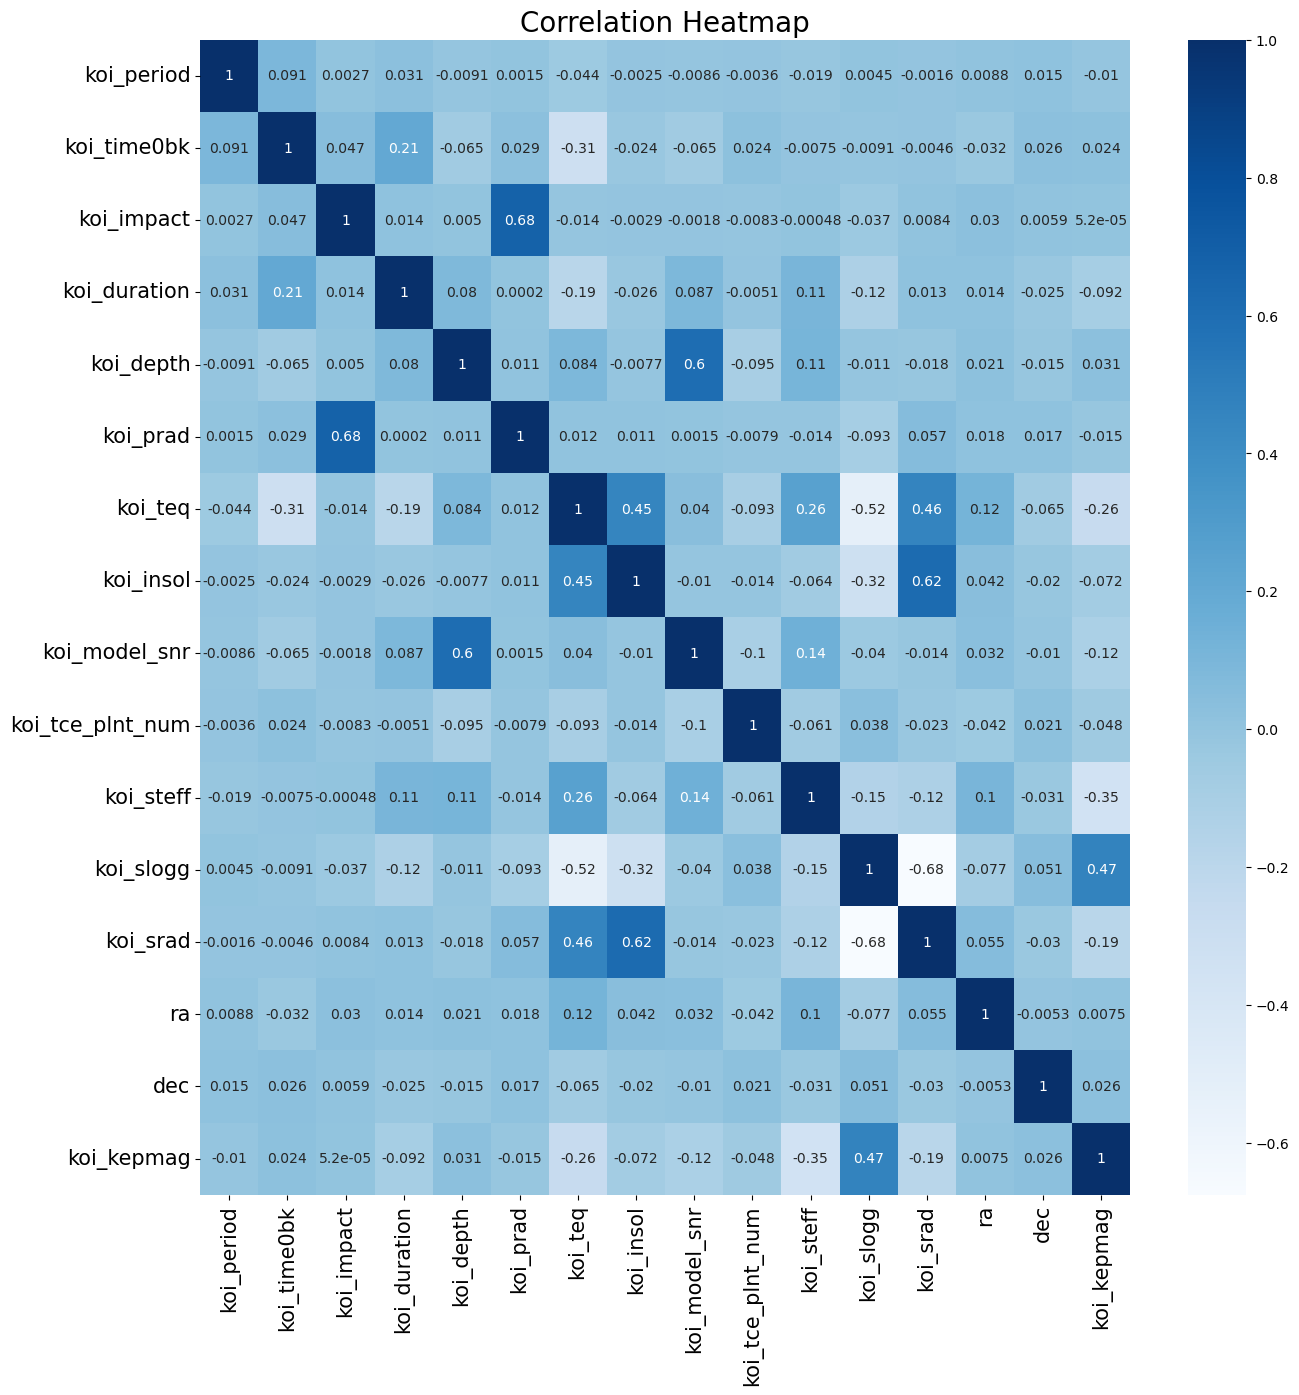

In [8]:
corr = X_train.drop(columns='koi_tce_delivname').corr()

plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True, cmap='Blues')
plt.title('Correlation Heatmap', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### Deal with Missing Values  

Review missing values and either remove or fill in missing values

In [9]:

# check missing values

def missing_value_count(df):
    """Return the percentage of missing values per column that has missing values"""
    nan_percents = df.isna().sum()/len(df)
    return nan_percents.loc[nan_percents>0]

X_train_nans = missing_value_count(X_train)
X_val_nans = missing_value_count(X_val)
X_test_nans = missing_value_count(X_test)

print(f'X_train Missing Values (Length - {len(X_train_nans)}):')
print(X_train_nans)
print('-'*100)
print(f'X_val Missing Values (Length - {len(X_val_nans)}):')
print(X_val_nans)
print('-'*100)
print(f'X_test Missing Values (Length - {len(X_test_nans)}):')
print(X_test_nans)
print('-'*100)

X_train Missing Values (Length - 11):
koi_impact           0.042524
koi_depth            0.042524
koi_prad             0.042524
koi_teq              0.042524
koi_insol            0.036598
koi_model_snr        0.042524
koi_tce_plnt_num     0.035030
koi_tce_delivname    0.035030
koi_steff            0.042524
koi_slogg            0.042524
koi_srad             0.042524
dtype: float64
----------------------------------------------------------------------------------------------------
X_val Missing Values (Length - 12):
koi_impact           0.033978
koi_depth            0.033978
koi_prad             0.033978
koi_teq              0.033978
koi_insol            0.031887
koi_model_snr        0.033978
koi_tce_plnt_num     0.042342
koi_tce_delivname    0.042342
koi_steff            0.033978
koi_slogg            0.033978
koi_srad             0.033978
koi_kepmag           0.000523
dtype: float64
----------------------------------------------------------------------------------------------------
X_te

It looks like koi_impact, koi_depth, koi_prad, koi_teq, koi_model_snr, koi_steff, koi_slogg, and koi_srad all have nan values in the same locations. And since it's only 4.3% of the data in the train set (3.4% in the validation set and 2.8% in the test set), I will initially drop those missing values.  

I will also drop the missing value in the koi_kepmag column since it seems that it's just one value that is missing.

In [10]:
# drop the rows from the columns where all of the values are missing
X_train = X_train.dropna(subset=['koi_impact', 'koi_teq', 'koi_model_snr', 'koi_steff', 'koi_slogg', 'koi_srad'], how='all')
X_val = X_val.dropna(subset=['koi_impact', 'koi_teq', 'koi_model_snr', 'koi_steff', 'koi_slogg', 'koi_srad'], how='all')
X_test = X_test.dropna(subset=['koi_impact', 'koi_teq', 'koi_model_snr', 'koi_steff', 'koi_slogg', 'koi_srad'], how='all')

# drop the one value that is missing the koi_kepmag in the validation set
X_val = X_val.dropna(subset='koi_kepmag')

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (5494, 17)
X_val shape: (1847, 17)
X_test shape: (1859, 17)


In [11]:
# check for missing values again

X_train_nans = missing_value_count(X_train)
X_val_nans = missing_value_count(X_val)
X_test_nans = missing_value_count(X_test)

print(f'X_train Missing Values (Length - {len(X_train_nans)}):')
print(X_train_nans)
print('-'*100)
print(f'X_val Missing Values (Length - {len(X_val_nans)}):')
print(X_val_nans)
print('-'*100)
print(f'X_test Missing Values (Length - {len(X_test_nans)}):')
print(X_test_nans)
print('-'*100)

X_train Missing Values (Length - 2):
koi_tce_plnt_num     0.02621
koi_tce_delivname    0.02621
dtype: float64
----------------------------------------------------------------------------------------------------
X_val Missing Values (Length - 2):
koi_tce_plnt_num     0.031944
koi_tce_delivname    0.031944
dtype: float64
----------------------------------------------------------------------------------------------------
X_test Missing Values (Length - 2):
koi_tce_plnt_num     0.027972
koi_tce_delivname    0.027972
dtype: float64
----------------------------------------------------------------------------------------------------


I will just remove the rows that are missing the koi_tce_plnt_num and koi_tce_delivname as well for simplicity sake.

In [12]:
# drop the rows from the columns where all of the values are missing
X_train = X_train.dropna(subset=['koi_tce_plnt_num', 'koi_tce_delivname'], how='all')
X_val = X_val.dropna(subset=['koi_tce_plnt_num', 'koi_tce_delivname'], how='all')
X_test = X_test.dropna(subset=['koi_tce_plnt_num', 'koi_tce_delivname'], how='all')

# keep the corresponding rows in the y variables to maintain consistency
y_train = y_train.loc[X_train.index]
y_val = y_val.loc[X_val.index]
y_test = y_test.loc[X_test.index]

# check missing values one last time
X_train_nans = missing_value_count(X_train)
X_val_nans = missing_value_count(X_val)
X_test_nans = missing_value_count(X_test)

print(f'X_train Missing Values (Length - {len(X_train_nans)}):')
print(X_train_nans)
print('-'*100)
print(f'X_val Missing Values (Length - {len(X_val_nans)}):')
print(X_val_nans)
print('-'*100)
print(f'X_test Missing Values (Length - {len(X_test_nans)}):')
print(X_test_nans)
print('-'*100)

# print shapes again
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)
print('y_test shape:', y_test.shape)

X_train Missing Values (Length - 0):
Series([], dtype: float64)
----------------------------------------------------------------------------------------------------
X_val Missing Values (Length - 0):
Series([], dtype: float64)
----------------------------------------------------------------------------------------------------
X_test Missing Values (Length - 0):
Series([], dtype: float64)
----------------------------------------------------------------------------------------------------
X_train shape: (5350, 17)
X_val shape: (1788, 17)
X_test shape: (1807, 17)
y_train shape: (5350,)
y_val shape: (1788,)
y_test shape: (1807,)


### Data Analysis  

Now that we have removed all the missing values, let's review the data to see any trends.  



In [13]:
# separate the features into their respective categores for easier plotting
X_train_transit_props = X_train[transit_prop_columns]
X_train_tce = X_train[tce_columns]
X_train_stellar_param = X_train[stellar_param_columns]

<Figure size 2000x2000 with 0 Axes>

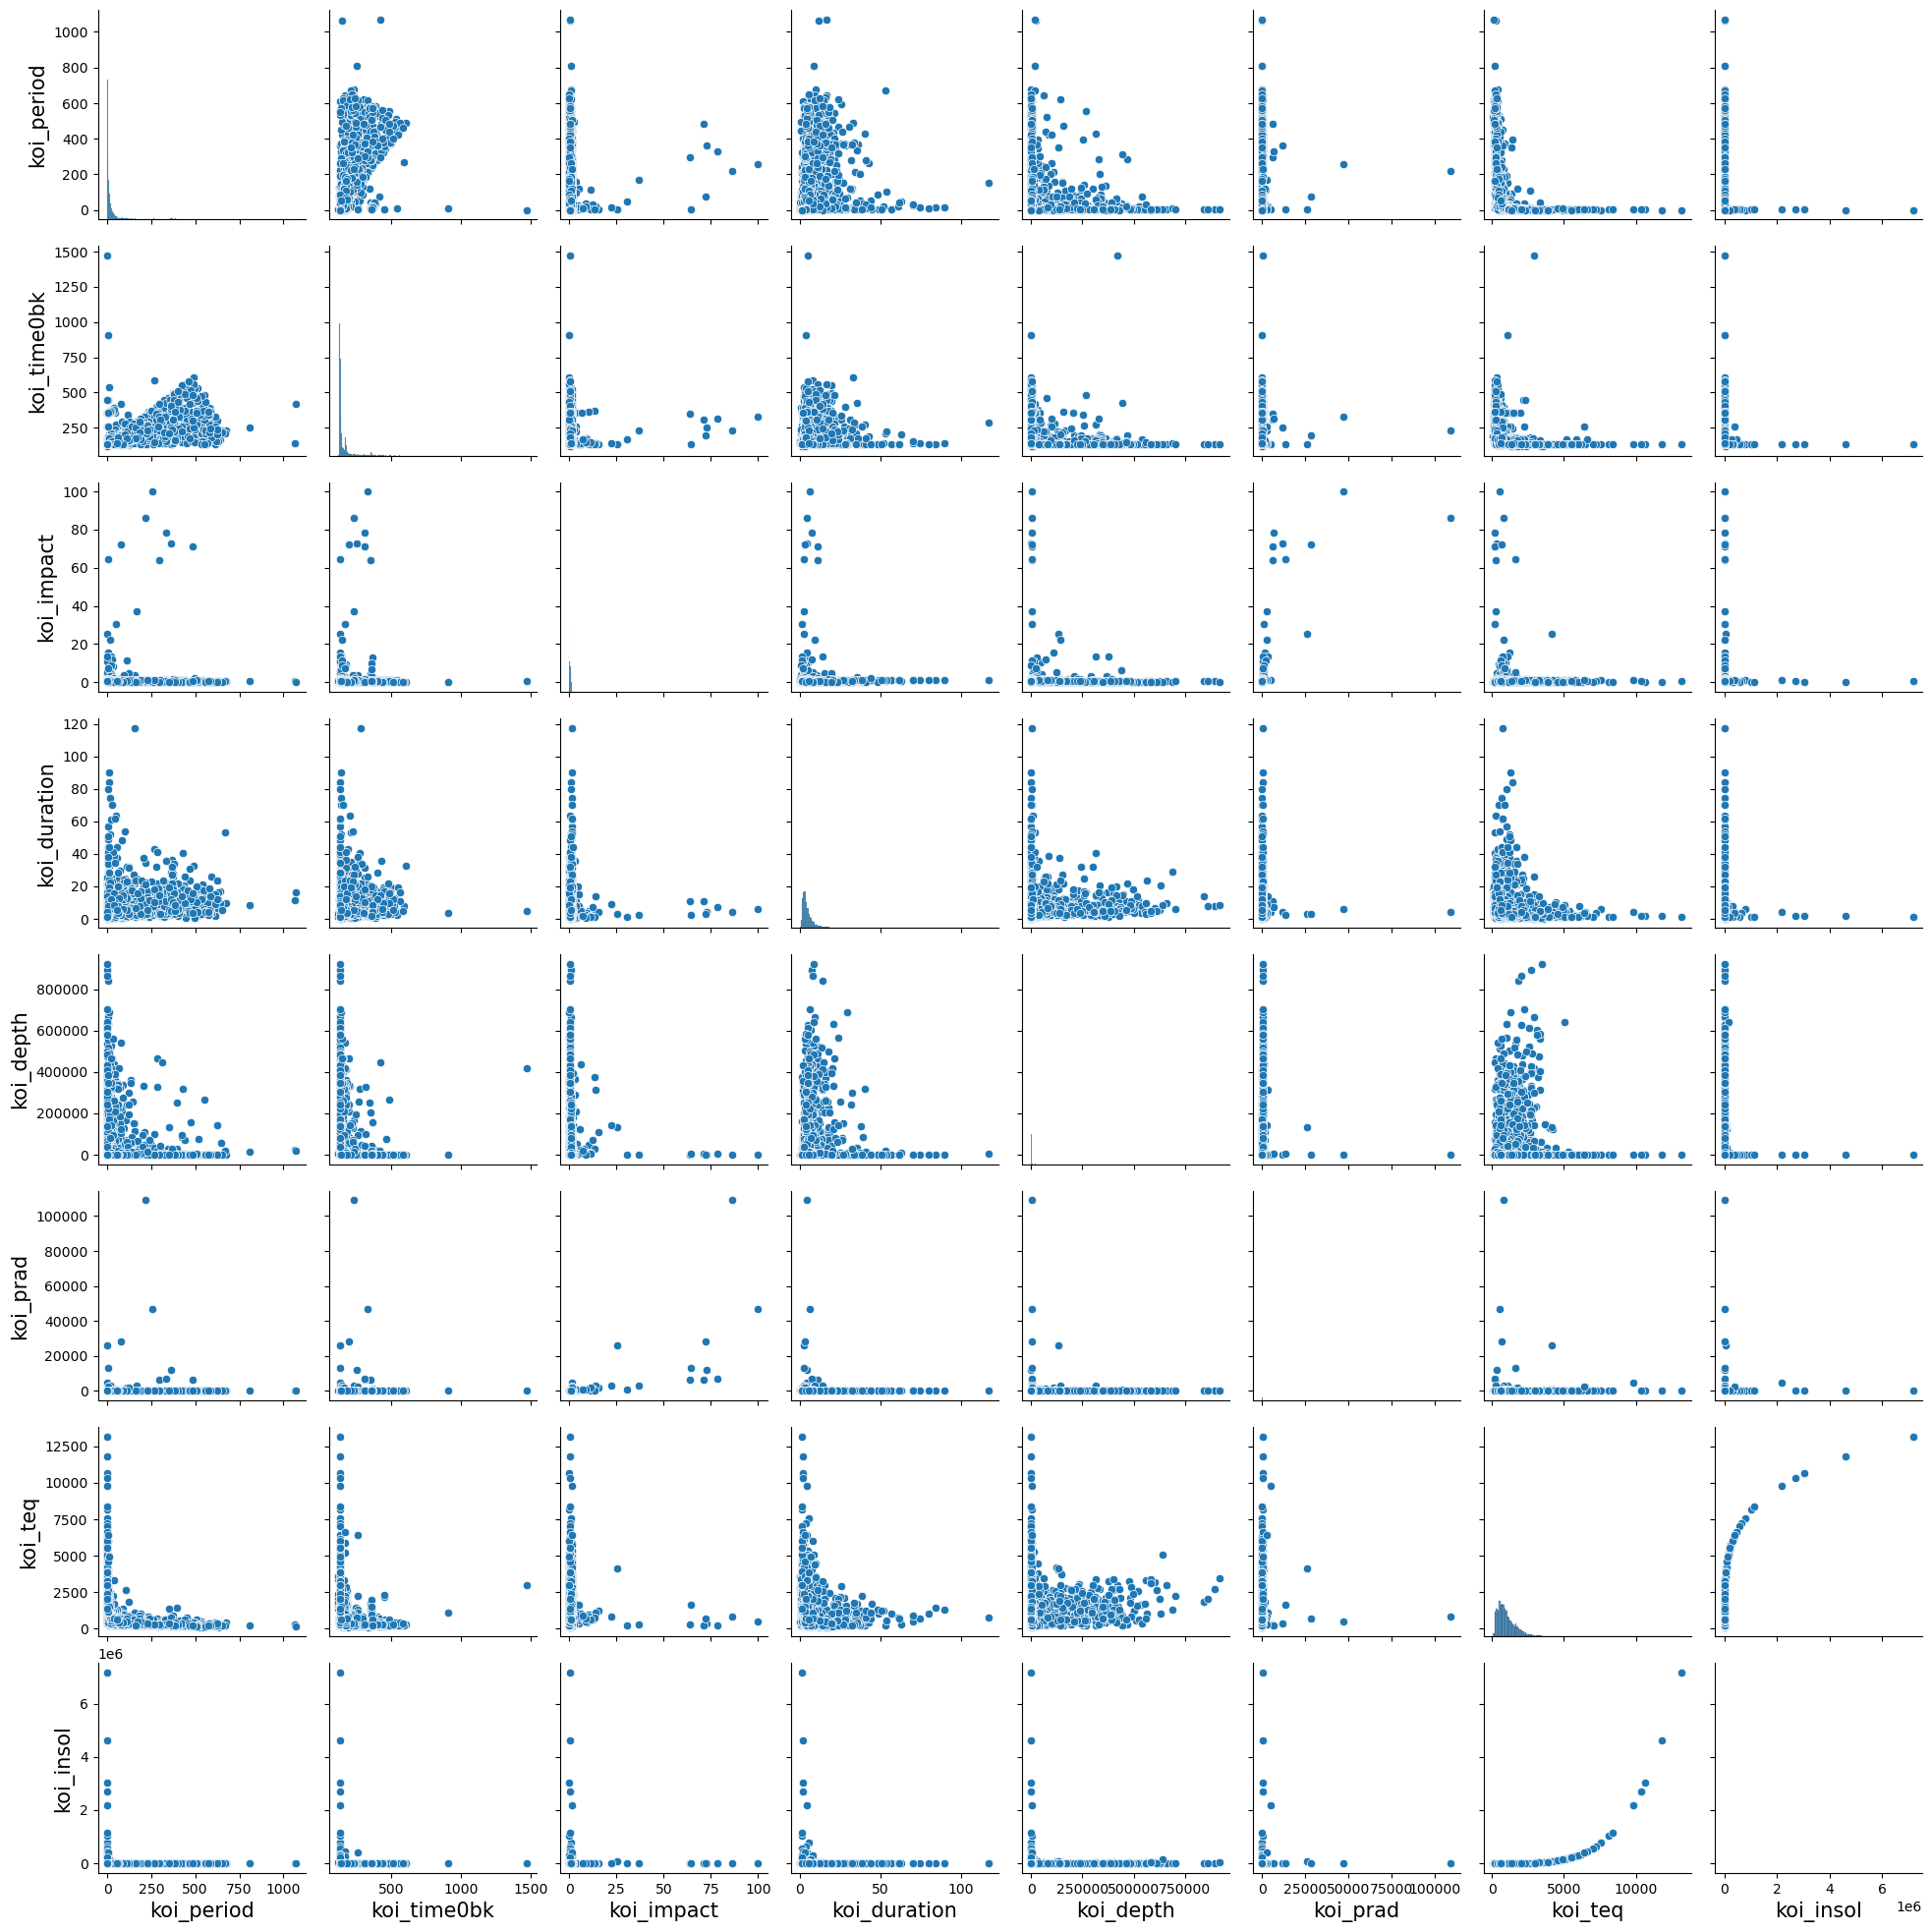

In [14]:
# pairplot of transit properties of the exoplanet
plt.rc('axes', labelsize=15)
plt.figure(figsize=(20,20))
sns.pairplot(X_train_transit_props)
plt.show()

<Figure size 640x480 with 0 Axes>

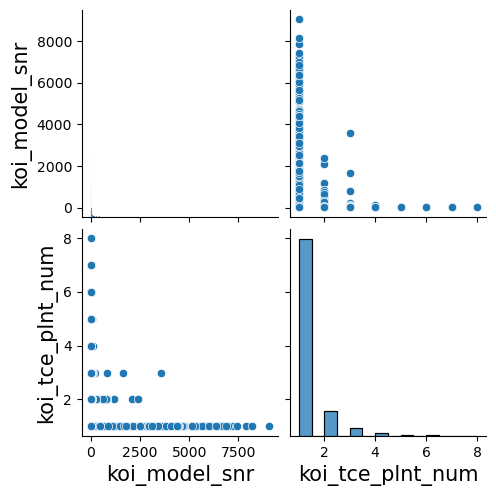

In [15]:
# pairplot of the tce features
plt.figure()
sns.pairplot(X_train_tce)
plt.show()

<Figure size 640x480 with 0 Axes>

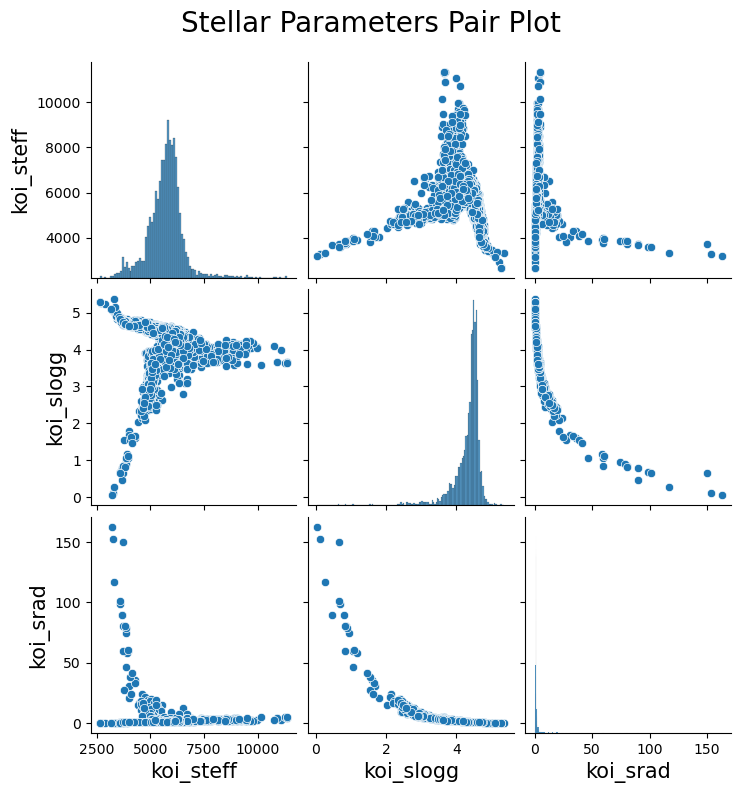

In [16]:
# pairplot of the stellar properties
plt.rc('axes', labelsize=15)
plt.figure()
sns.pairplot(X_train_stellar_param)
plt.suptitle('Stellar Parameters Pair Plot', fontsize=20, y=1.05)
plt.show()

## Feature Engineering  

Let's transform a lot of these features now.  

### Log Transformations

Starting with Numeric Features, it looks like all of the transit property columns are right skewed. Will log transform all of them along with the tce columns, and koi_srad. We will not do a log transform of koi_tce_plnt_num because those look to be distinct buckets of the planet number. We will one hot encode this feature later.

In [17]:
# copy all of the data sets for log transformations
X_train_log = X_train.copy()
X_val_log = X_val.copy()
X_test_log = X_test.copy()

# column names that need log transformations
log_transform_columns = transit_prop_columns + ['koi_model_snr', 'koi_srad']

# log transform all of the columns listed above
X_train_log[log_transform_columns] = X_train_log[log_transform_columns].apply(np.log1p)
X_val_log[log_transform_columns] = X_val_log[log_transform_columns].apply(np.log1p)
X_test_log[log_transform_columns] = X_test_log[log_transform_columns].apply(np.log1p)

# add the target variable back in for better visualization
X_train_log_temp = X_train_log.copy()
X_train_log_temp['target'] = y_train

<Figure size 2000x2000 with 0 Axes>

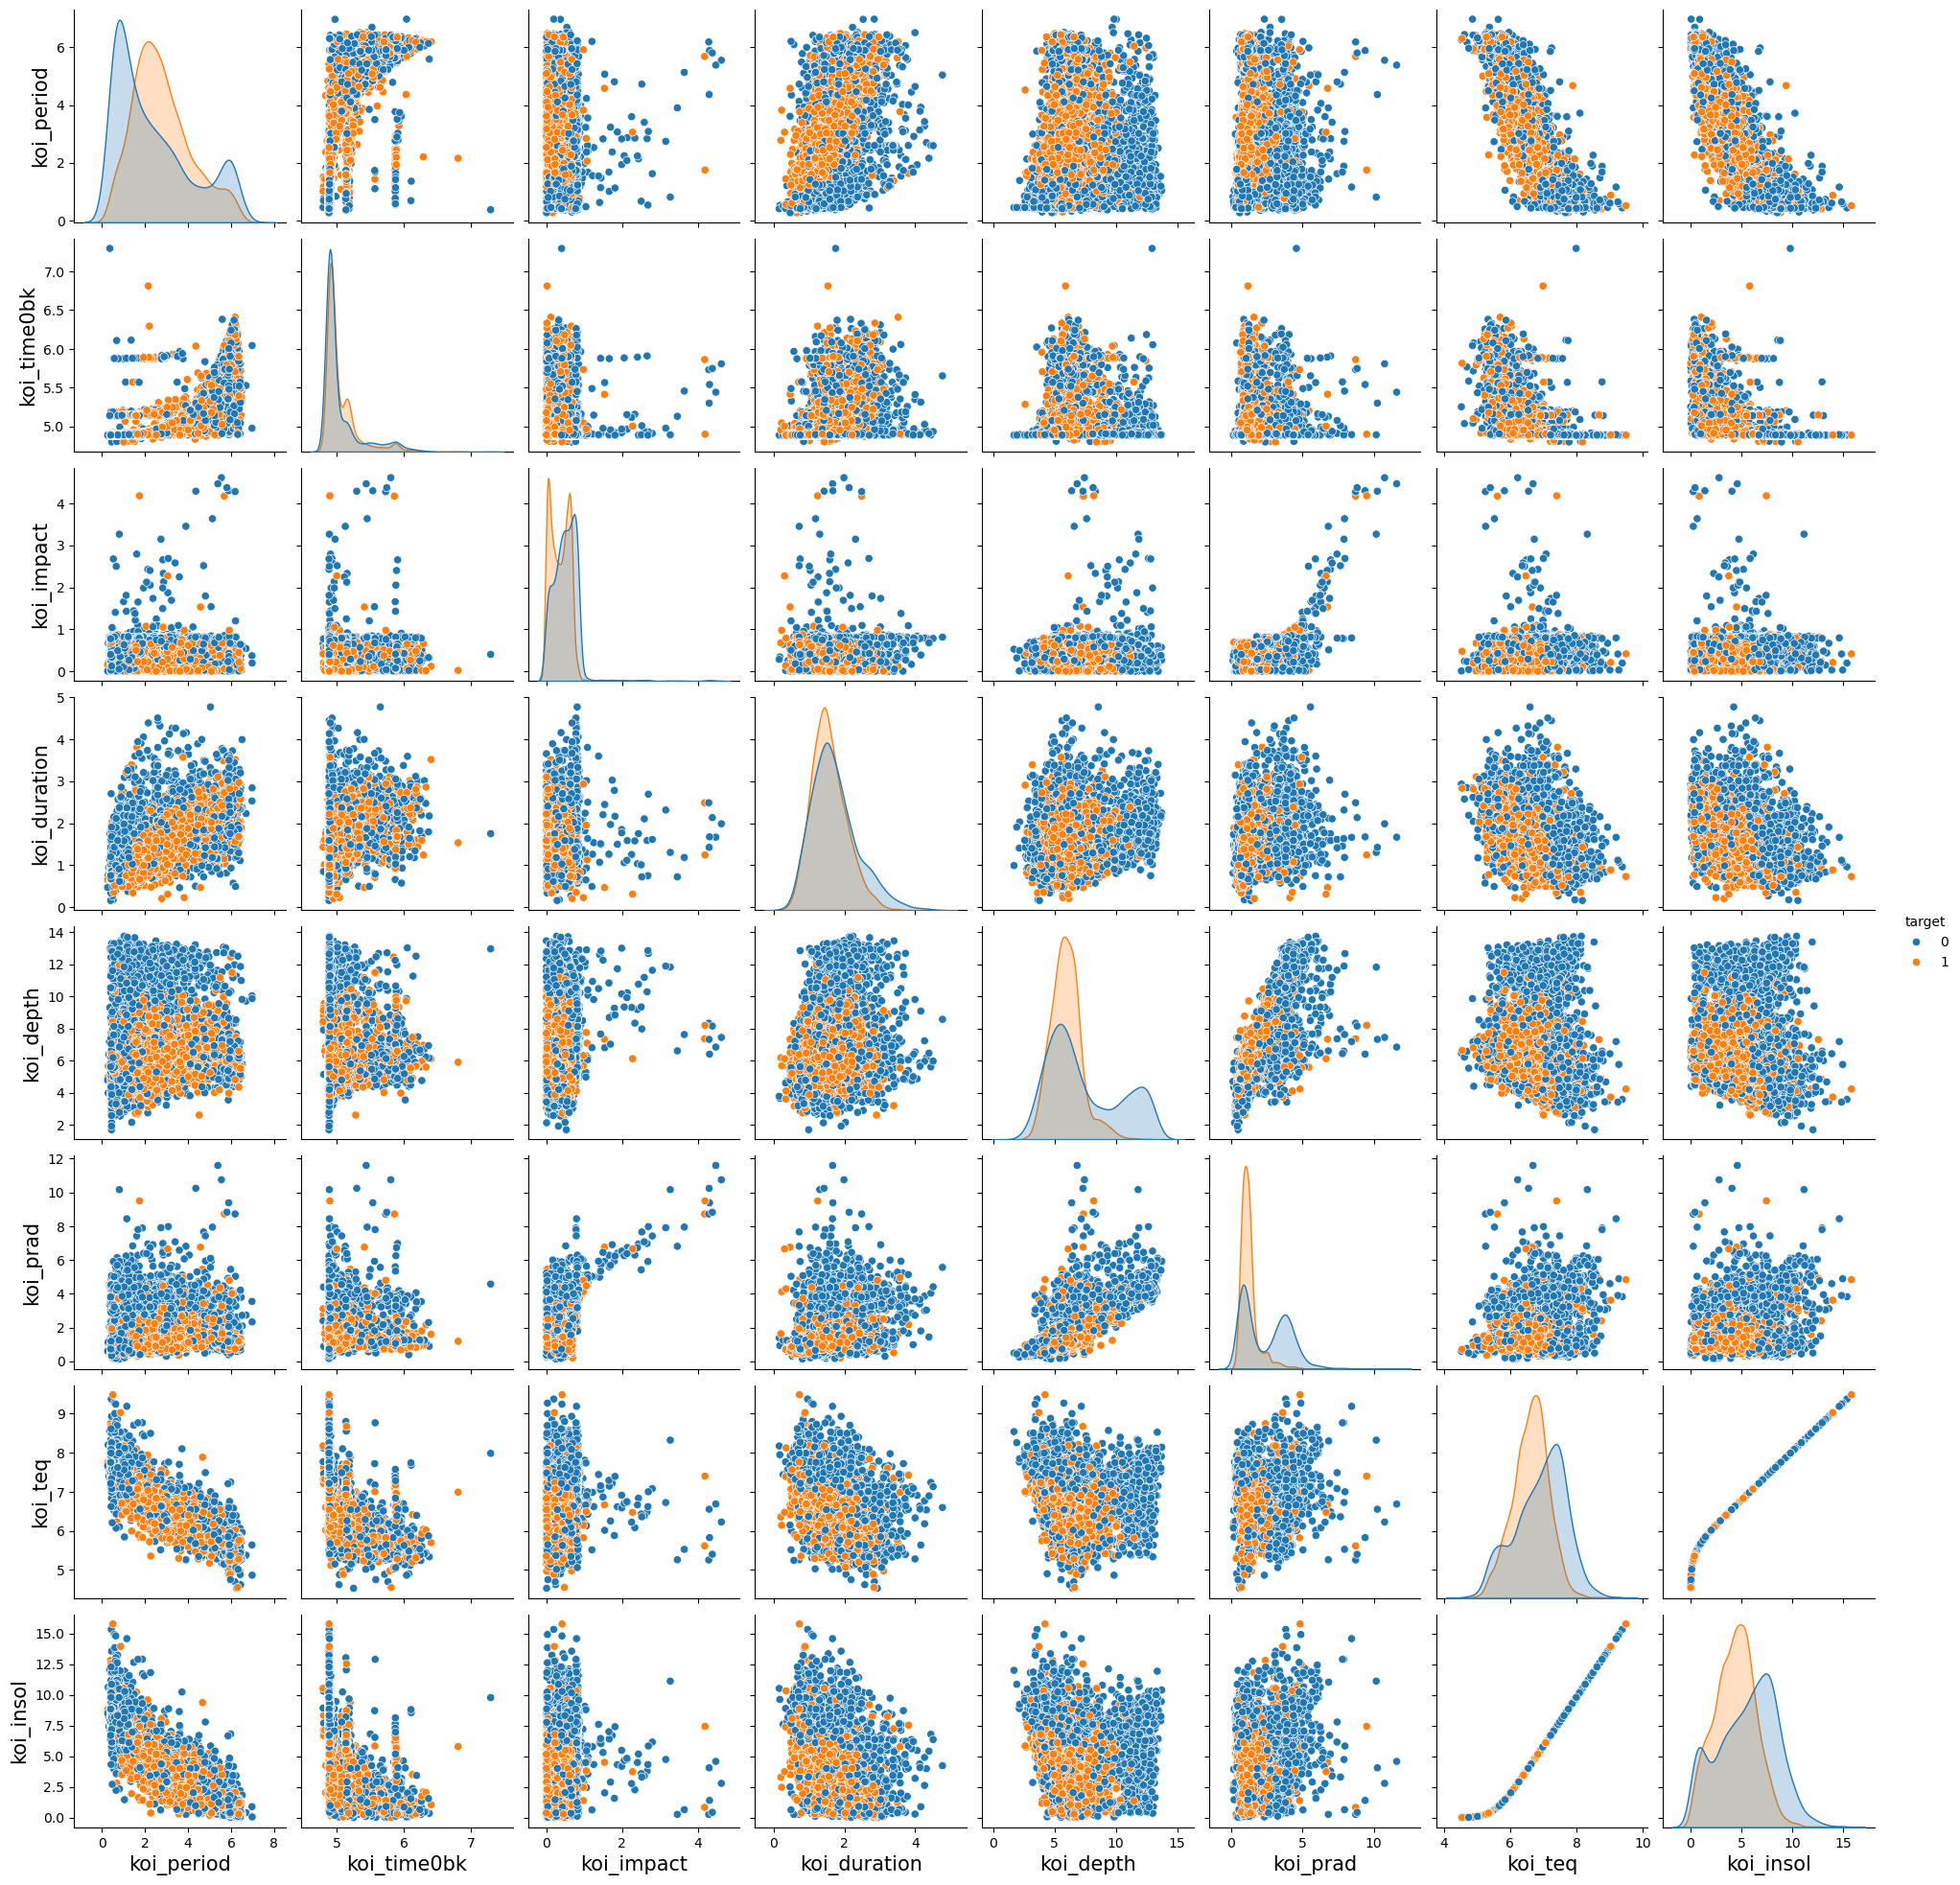

In [18]:
# get all transit features plus the target column
X_train_log_temp_transit = X_train_log_temp[transit_prop_columns+['target']]

# create pairplot colored by disposition column
plt.figure(figsize=(20,20))
sns.pairplot(X_train_log_temp_transit, hue='target')
plt.show()

<Figure size 640x480 with 0 Axes>

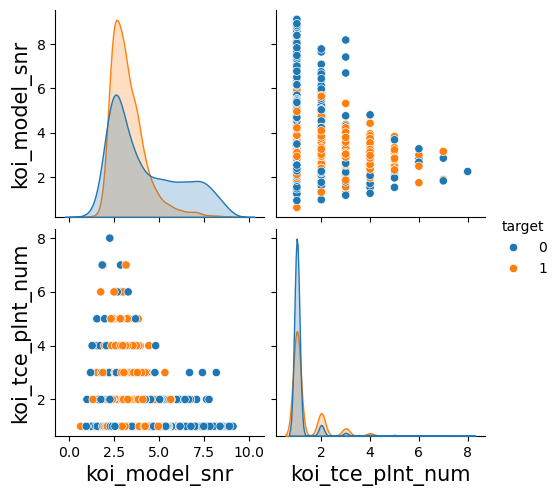

In [19]:
# create pairplot colored by disposition column
X_train_log_temp_tce = X_train_log_temp[tce_columns + ['target']]
plt.figure()
sns.pairplot(X_train_log_temp_tce, hue='target')
plt.show()

<Figure size 640x480 with 0 Axes>

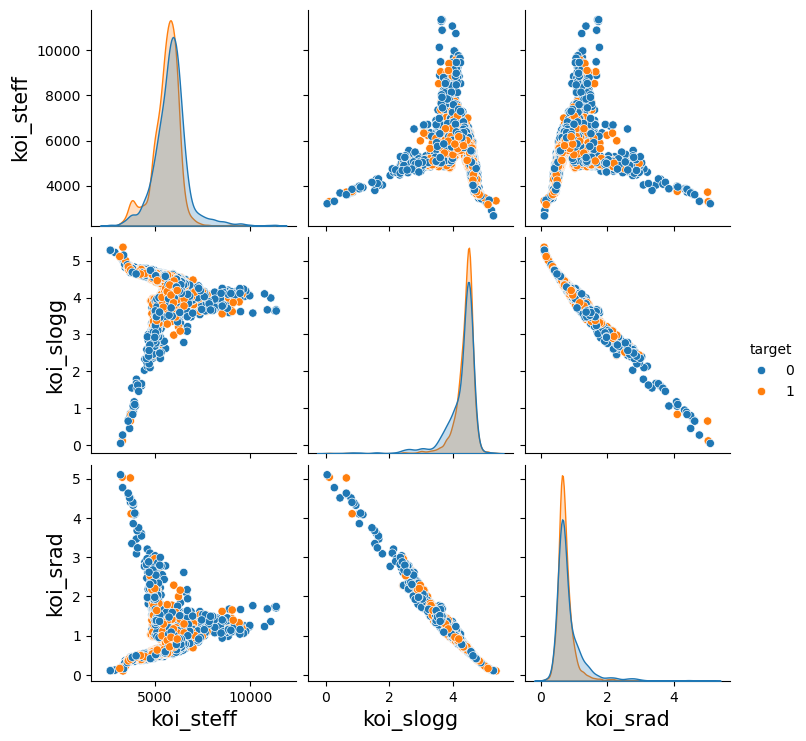

In [20]:
# create pairplot colored by disposition column
X_train_log_temp_stellar = X_train_log_temp[stellar_param_columns + ['target']]

plt.figure()
sns.pairplot(X_train_log_temp_stellar, hue='target')
plt.show()

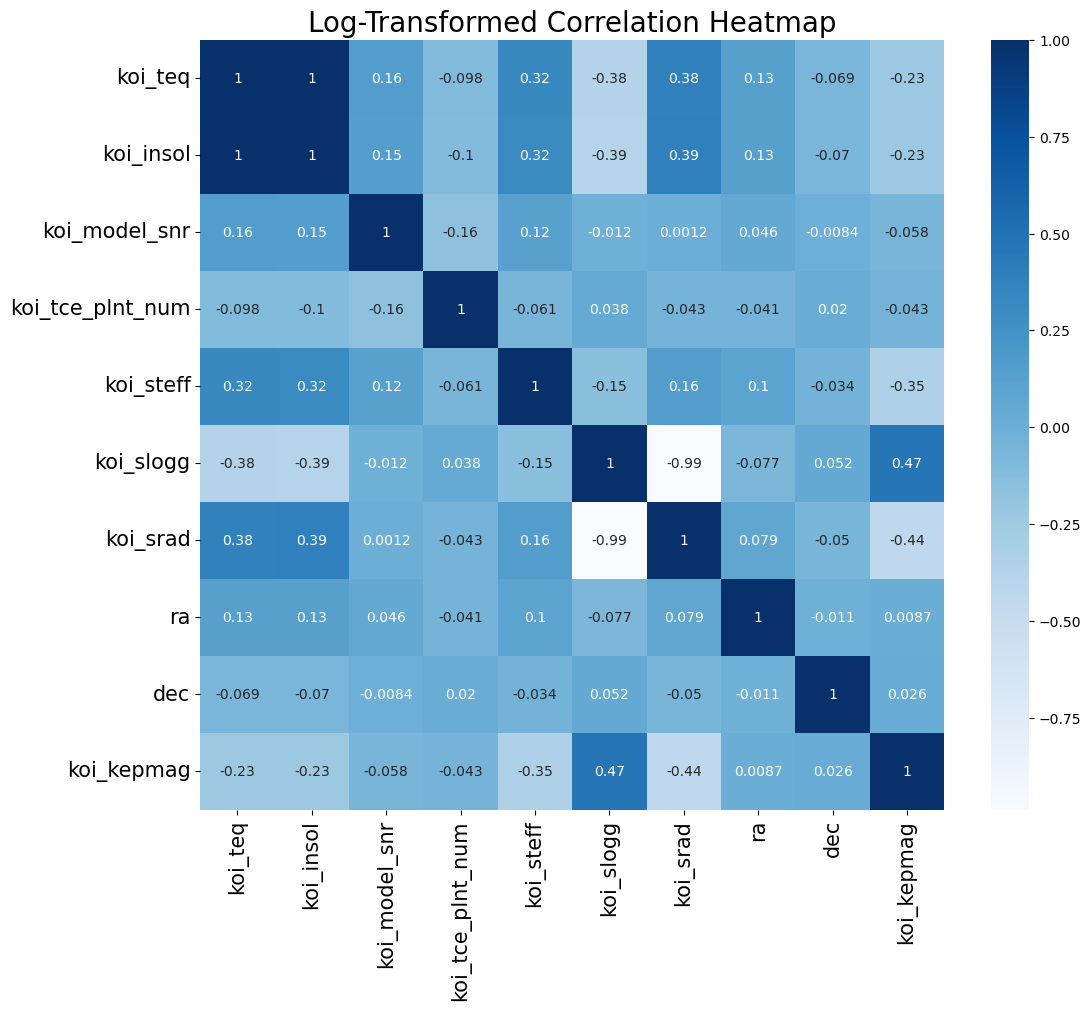

In [21]:
# replot correlation matrix
corr = X_train_log.drop(columns='koi_tce_delivname').corr()
corr_reduced = corr.iloc[6:,6:]

plt.figure(figsize=(12,10))
sns.heatmap(corr_reduced, annot=True, cmap='Blues')
plt.title('Log-Transformed Correlation Heatmap', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

It makes sense that the log of stellar surface gravitational acceleration (koi_slogg) is almost perfectly correlated with the log of the stellar radius (koi_srad) since gravitational acceleration is inversely proportional to the radius squared. As a result, this is redundant information and we can remove one of the two variables. I will remove koi_srad as the gravitational acceleration can contain information about the mass of the star as well.  

There is also perfect collinearity between the log of koi_teq and the log of koi_insol or the Equilibrium Temperature of the planet and the Insolation Flux of the planet, respectively. Based on the description from the data dictionary, it looks like both of these variables describe the same thing. The description for the Insolation Flux is "Insolation flux is another way to give the equilibrium temperature. It depends on the stellar parameters (specifically the stellar radius and temperature), and on the semi-major axis of the planet. It's given in units relative to those measured for the Earth from the Sun." As a result, we can remove one of them and still keep the same information. I will remove koi_insol.

In [22]:
# drop koi_srad and koi_insol
X_train_log = X_train_log.drop(columns=['koi_srad', 'koi_insol'])
X_val_log = X_val_log.drop(columns=['koi_srad', 'koi_insol'])
X_test_log = X_test_log.drop(columns=['koi_srad', 'koi_insol'])


X_train_log.shape


(5350, 15)

From the pairplot colored by the target variable, it seems that koi_depth and koi_prad might benefit from a binary binning. More so that the outliers for these two variables tend to be false positives.  

First look at the distributions more closely.

Text(0.5, 0.98, 'Histograms for Non-Normal Columns')

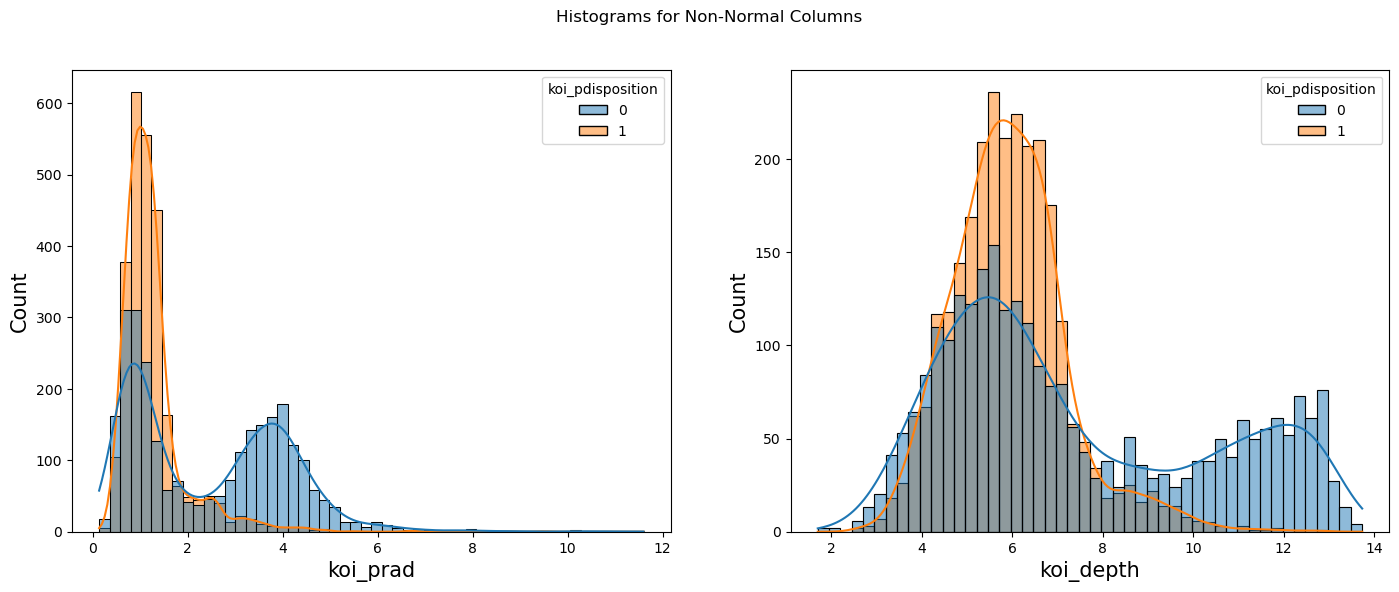

In [23]:
# look at histograms closer for non-normal distributions
fig, axes = plt.subplots(1,2, figsize=(17,6))

non_normal_list = ['koi_prad', 'koi_depth']

for i, col in enumerate(non_normal_list):
    sns.histplot(X_train_log, x=col, hue=y_train, ax=axes[i], kde=True)

fig.suptitle('Histograms for Non-Normal Columns')

In [24]:
# binning the two variables based on histogram data
X_train_log['koi_prad_binned'] = X_train_log['koi_prad'] <= 3
X_train_log['koi_depth_binned'] = X_train_log['koi_depth'] <= 10

# convert to int for Tensorflow
X_train_log['koi_prad_binned'] = X_train_log['koi_prad_binned'].astype(int)
X_train_log['koi_depth_binned'] = X_train_log['koi_depth_binned'].astype(int)

# repeat for validation dataset
X_val_log['koi_prad_binned'] = X_val_log['koi_prad'] <= 3
X_val_log['koi_depth_binned'] = X_val_log['koi_depth'] <= 10
X_val_log['koi_prad_binned'] = X_val_log['koi_prad_binned'].astype(int)
X_val_log['koi_depth_binned'] = X_val_log['koi_depth_binned'].astype(int)

# repeat for test dataset
X_test_log['koi_prad_binned'] = X_test_log['koi_prad'] <= 3
X_test_log['koi_depth_binned'] = X_test_log['koi_depth'] <= 10
X_test_log['koi_prad_binned'] = X_test_log['koi_prad_binned'].astype(int)
X_test_log['koi_depth_binned'] = X_test_log['koi_depth_binned'].astype(int)

X_train_log

koi_period  koi_time0bk  koi_impact  koi_duration  koi_depth  koi_prad  \
3436    2.912712     5.147534    0.021761      2.062295   6.376557  1.373716   
416     0.704423     4.901224    0.018822      0.863396   4.869072  0.760806   
6382    4.029788     5.111861    0.579418      1.816691  12.234033  4.123742   
2391    2.708682     4.897612    0.237441      1.481377   5.141079  0.683097   
2947    5.300530     5.488324    0.658556      2.129303   8.303257  2.332144   
...          ...          ...         ...           ...        ...       ...   
886     1.656615     4.901231    0.228728      1.379018   5.242276  0.891998   
7763    0.736722     4.890531    0.488580      1.585842  12.625017  4.364244   
7163    0.407596     4.889644    0.400118      0.750000   5.622572  0.722706   
6401    4.111769     5.208867    0.289306      1.489528   5.790266  1.830980   
2464    4.012433     4.953828    0.615186      1.874414   5.002603  1.121678   

       koi_teq  koi_model_snr  koi_tce_plnt_num koi_tce_delivname  koi_steff  \
3436  6.703188       4.462454               1.0   q1_q17_dr25_tce     6086.0   
416   7.458763       3.117950               1.0   q1_q17_dr25_tce     5366.0   
6382  6.208590       8.147143               1.0   q1_q17_dr25_tce     6063.0   
2391  6.426488       3.161247               1.0   q1_q17_dr25_tce     5153.0   
2947  5.808142       4.027136               1.0   q1_q17_dr25_tce     5646.0   
...        ...            ...               ...               ...        ...   
886   7.071573       2.944439               1.0   q1_q17_dr25_tce     5776.0   
7763  7.623642       6.168774               1.0   q1_q17_dr25_tce     6126.0   
7163  7.218177       2.406945               1.0   q1_q17_dr25_tce     4013.0   
6401  6.543912       2.549445               1.0        q1_q16_tce     5242.0   
2464  6.405228       3.044522               3.0   q1_q17_dr25_tce     6170.0   

      koi_slogg         ra        dec  koi_kepmag  koi_prad_binned  \
3436      4.274  293.72806  46.129150      13.998                1   
416       4.363  296.68045  41.386520      14.803                1   
6382      4.476  288.15308  43.473560      14.925                0   
2391      4.551  299.65961  40.843849      13.380                1   
2947      4.278  281.76578  44.576370      14.546                1   
...         ...        ...        ...         ...              ...   
886       4.340  295.21664  38.774330      14.621                1   
7763      4.285  288.02032  46.324139       9.177                0   
7163      4.639  286.17670  42.196529      14.155                1   
6401      3.606  287.37115  46.051189      13.571                1   
2464      4.192  289.92145  46.744560      12.805                1   

      koi_depth_binned  
3436                 1  
416                  1  
6382                 0  
2391                 1  
2947                 1  
...                ...  
886                  1  
7763                 0  
7163                 1  
6401                 1  
2464                 1  

[5350 rows x 17 columns]

Text(0.5, 0.98, 'Histogram of Non-Normal Distributions Colored by Disposition')

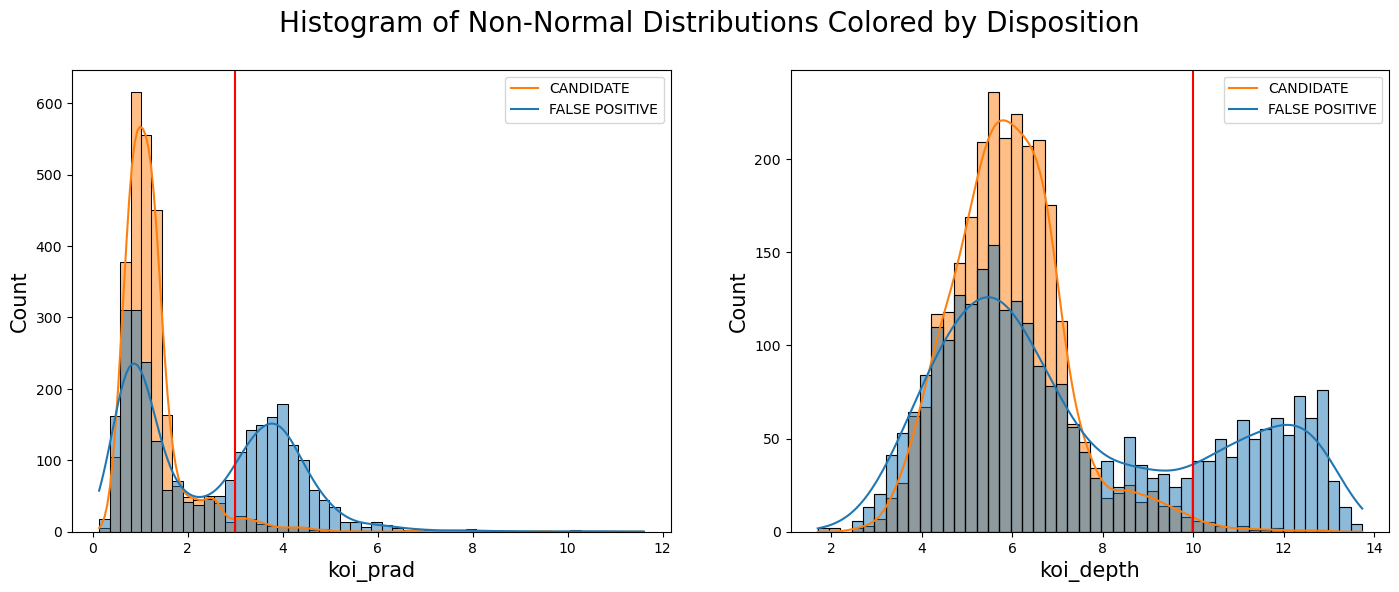

In [25]:
# replot the distributions along with a vertical line for bin boundary
fig, axes = plt.subplots(1,2, figsize=(17,6))

for i, col in enumerate(non_normal_list):
    binned_col = f'{col}_binned'
    sns.histplot(X_train_log, x=col, ax=axes[i], hue=y_train, kde=True)
    axes[i].legend(['CANDIDATE','FALSE POSITIVE'])

axes[0].axvline(x=3, color='red')
axes[1].axvline(x=10, color='red')

fig.suptitle('Histogram of Non-Normal Distributions Colored by Disposition', fontsize=20)

It seems that 4 seems to capture the different nodes, although it also seems to cut through some of the nodes as well. Let's give it a shot to see how well it does. We will drop the original columns and keep the binned ones. With the binned ones, we will one hot encode them in a later section.

In [26]:
# drop numeric columns that we just binned
X_train_log = X_train_log.drop(columns=non_normal_list)
X_val_log = X_val_log.drop(columns=non_normal_list)
X_test_log = X_test_log.drop(columns=non_normal_list)

X_train_log.head()

koi_period  koi_time0bk  koi_impact  koi_duration   koi_teq  \
3436    2.912712     5.147534    0.021761      2.062295  6.703188   
416     0.704423     4.901224    0.018822      0.863396  7.458763   
6382    4.029788     5.111861    0.579418      1.816691  6.208590   
2391    2.708682     4.897612    0.237441      1.481377  6.426488   
2947    5.300530     5.488324    0.658556      2.129303  5.808142   

      koi_model_snr  koi_tce_plnt_num koi_tce_delivname  koi_steff  koi_slogg  \
3436       4.462454               1.0   q1_q17_dr25_tce     6086.0      4.274   
416        3.117950               1.0   q1_q17_dr25_tce     5366.0      4.363   
6382       8.147143               1.0   q1_q17_dr25_tce     6063.0      4.476   
2391       3.161247               1.0   q1_q17_dr25_tce     5153.0      4.551   
2947       4.027136               1.0   q1_q17_dr25_tce     5646.0      4.278   

             ra        dec  koi_kepmag  koi_prad_binned  koi_depth_binned  
3436  293.72806  46.129150      13.998                1                 1  
416   296.68045  41.386520      14.803                1                 1  
6382  288.15308  43.473560      14.925                0                 0  
2391  299.65961  40.843849      13.380                1                 1  
2947  281.76578  44.576370      14.546                1                 1

### Robust Scaling Numeric Features

Standardize all of the columns now. Will be using a RobustScalar because it looks like most of the numeric columns have outliers and it is more robust to outliers. I will one hot encode koi_tce_plnt_num since it only has distinct integer categories and would not benefit from Robust scaling.

In [27]:
# get only the numeric columns
numeric_cols = X_train_log.select_dtypes(include='float').columns
numeric_cols = numeric_cols.drop('koi_tce_plnt_num')

# instantiate the RobustScaler
robust_scaler = RobustScaler()

# transform all numeric columns using RobustScaler
X_train_log[numeric_cols] = robust_scaler.fit_transform(X_train_log[numeric_cols])
X_val_log[numeric_cols] = robust_scaler.transform(X_val_log[numeric_cols])
X_test_log[numeric_cols] = robust_scaler.transform(X_test_log[numeric_cols])

X_train_log.head()

koi_period  koi_time0bk  koi_impact  koi_duration   koi_teq  \
3436    0.275402     0.908304   -0.915328      0.696873 -0.091637   
416    -0.708623    -0.101218   -0.921839     -0.943846  0.726235   
6382    0.773176     0.762091    0.319817      0.360758 -0.627015   
2391    0.184485    -0.116021   -0.437623     -0.098126 -0.391151   
2947    1.339425     2.305052    0.495097      0.788574 -1.060479   

      koi_model_snr  koi_tce_plnt_num koi_tce_delivname  koi_steff  koi_slogg  \
3436       0.695675               1.0   q1_q17_dr25_tce   0.396530  -0.506173   
416       -0.043240               1.0   q1_q17_dr25_tce  -0.495663  -0.231481   
6382       2.720715               1.0   q1_q17_dr25_tce   0.368030   0.117284   
2391      -0.019445               1.0   q1_q17_dr25_tce  -0.759603   0.348765   
2947       0.456432               1.0   q1_q17_dr25_tce  -0.148699  -0.493827   

            ra       dec  koi_kepmag  koi_prad_binned  koi_depth_binned  
3436  0.189876  0.421188   -0.273146                1                 1  
416   0.597131 -0.377468    0.162696                1                 1  
6382 -0.579142 -0.026012    0.228749                0                 0  
2391  1.008079 -0.468854   -0.607742                1                 1  
2947 -1.460212  0.159701    0.023552                1                 1

### Categorical Feature  

We only have one categorical feature so we will analyze the distribution of this and determine if there's a good way to make it suitable for a model

In [28]:
# view the different categories of the delivname
X_train_log['koi_tce_delivname'].value_counts()

koi_tce_delivname
q1_q17_dr25_tce    4776
q1_q16_tce          371
q1_q17_dr24_tce     203
Name: count, dtype: int64

There are very few categories, so I will just one hot encode this column as well. As a reminder, koi_tce_plnt_num is also a categorical variable that is label encoded already so we will also one hot encode that as well.

In [29]:
onehot_encoder = OneHotEncoder(sparse_output=False)

onehot_columns = ['koi_tce_delivname', 'koi_tce_plnt_num']

# one hot encode the two categorical variables
X_train_onehot = onehot_encoder.fit_transform(X_train_log[onehot_columns])
X_val_onehot = onehot_encoder.transform(X_val_log[onehot_columns])
X_test_onehot = onehot_encoder.transform(X_test_log[onehot_columns])

# drop the columns that have been one hot encoded
X_train_log = X_train_log.drop(columns=onehot_columns)
X_val_log = X_val_log.drop(columns=onehot_columns)
X_test_log = X_test_log.drop(columns=onehot_columns)

# convert the non one hot encoded columns to numpy arrays
X_train_standardized = X_train_log.to_numpy()
X_val_standardized = X_val_log.to_numpy()
X_test_standardized = X_test_log.to_numpy()

print('X_train head:')
print(X_train_standardized[:5])


X_train head:
[[ 0.2754017   0.9083036  -0.91532813  0.69687316 -0.09163687  0.69567523
   0.39653036 -0.50617284  0.18987562  0.42118802 -0.27314564  1.
   1.        ]
 [-0.70862298 -0.1012179  -0.9218393  -0.94384582  0.72623518 -0.04324014
  -0.49566295 -0.23148148  0.5971309  -0.37746816  0.16269626  1.
   1.        ]
 [ 0.7731764   0.76209137  0.31981701  0.36075846 -0.62701479  2.72071483
   0.36802974  0.11728395 -0.57914203 -0.02601182  0.22874932  0.
   0.        ]
 [ 0.18448505 -0.11602124 -0.43762345 -0.09812562 -0.39115054 -0.01944499
  -0.75960347  0.34876543  1.00807885 -0.46885364 -0.60774228  1.
   1.        ]
 [ 1.33942515  2.30505234  0.49509696  0.7885739  -1.06047941  0.45643219
  -0.14869888 -0.49382716 -1.46021182  0.15970075  0.02355171  1.
   1.        ]]


In [30]:
# concatenate both arrays to be used for modelling
X_train_final = np.concatenate((X_train_standardized, X_train_onehot), axis=1)
X_val_final = np.concatenate((X_val_standardized, X_val_onehot), axis=1)
X_test_final = np.concatenate((X_test_standardized, X_test_onehot), axis=1)

# convert the y variable to numpy too
y_train_final = y_train.to_numpy()
y_val_final = y_val.to_numpy()
y_test_final = y_test.to_numpy()

print('X_train_final shape:', X_train_final.shape)
print('X_val_final shape:', X_val_final.shape)
print('X_test_final_shape:', X_test_final.shape)

X_train_final shape: (5350, 24)
X_val_final shape: (1788, 24)
X_test_final_shape: (1807, 24)


## Modelling  

Now that we've transformed and standardized all the columns. It is time for modelling.  

### Baseline Model  

We will start with a baseline model our more complicated model will compare. We will use a logistic regression as our baseline.

In [31]:
# create logistic regression model
linear_model = LogisticRegression()

# use cross validation for determining scores
cv_scores = cross_val_score(linear_model, X_train_final, y_train_final, cv=5)

print('Scores;', cv_scores)
print('Mean Score:', np.mean(cv_scores))

Scores; [0.80841121 0.80373832 0.8046729  0.81775701 0.78785047]
Mean Score: 0.8044859813084113


### Random Forest Model

In [32]:
rf_model = RandomForestClassifier(n_estimators=500)

rf_model.fit(X_train_final, y_train_final)

rf_cv_scores = cross_val_score(rf_model, X_train_final, y_train_final, cv=5)

print('Scores:', rf_cv_scores)
print('Mean Score:', np.mean(rf_cv_scores))


Scores: [0.8411215  0.8364486  0.84299065 0.84859813 0.82897196]
Mean Score: 0.839626168224299


### TensorFlow Model  

Now we will use TensorFlow to determine if it does any better.

In [33]:
def build_model(num_features, activation='relu', optimizer='Adam', learning_rate=0.01):
    """Create a neural network model """

    # clear the current session to create new model
    # set seed for reproduceable results
    tf.keras.backend.clear_session()
    tf.random.set_seed(207)

    input_layer = tf.keras.layers.Input(shape=(num_features,)) # input layer
    dropout_rate = 0.3 # dropout rate

    # 4 dense layers with dropout layers in between each
    hidden_layers = tf.keras.layers.Dense(256, activation= activation)(input_layer) 
    hidden_layers = tf.keras.layers.Dropout(dropout_rate)(hidden_layers)
    hidden_layers = tf.keras.layers.Dense(128, activation= activation)(hidden_layers)
    hidden_layers = tf.keras.layers.Dropout(dropout_rate)(hidden_layers)
    hidden_layers = tf.keras.layers.Dense(64, activation= activation)(hidden_layers)
    hidden_layers = tf.keras.layers.Dropout(dropout_rate)(hidden_layers)
    hidden_layers = tf.keras.layers.Dense(32, activation=activation)(hidden_layers)

    # output layer with sigmoid activation
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(hidden_layers)

    # build model
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

    # change optimizer based on the string input
    if optimizer == 'SGD':
        optimizer_ = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'Adam':
        optimizer_ = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    # compile model
    model.compile(optimizer=optimizer_, loss='binary_crossentropy', metrics=['accuracy'])

    return model

Epoch 1/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5229 - loss: 0.7020 - val_accuracy: 0.5694 - val_loss: 0.6880
Epoch 2/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5343 - loss: 0.6943 - val_accuracy: 0.6286 - val_loss: 0.6782
Epoch 3/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5607 - loss: 0.6845 - val_accuracy: 0.6600 - val_loss: 0.6691
Epoch 4/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5828 - loss: 0.6790 - val_accuracy: 0.6913 - val_loss: 0.6608
Epoch 5/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6003 - loss: 0.6729 - val_accuracy: 0.7019 - val_loss: 0.6525
Epoch 6/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6174 - loss: 0.6638 - val_accuracy: 0.7086 - val_loss: 0.6442
Epoch 7/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6363 - loss: 0.6573 - val_accuracy: 0.7170 - val_loss: 0.6358
Epoch 8/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6460 - loss: 0.6486 - 

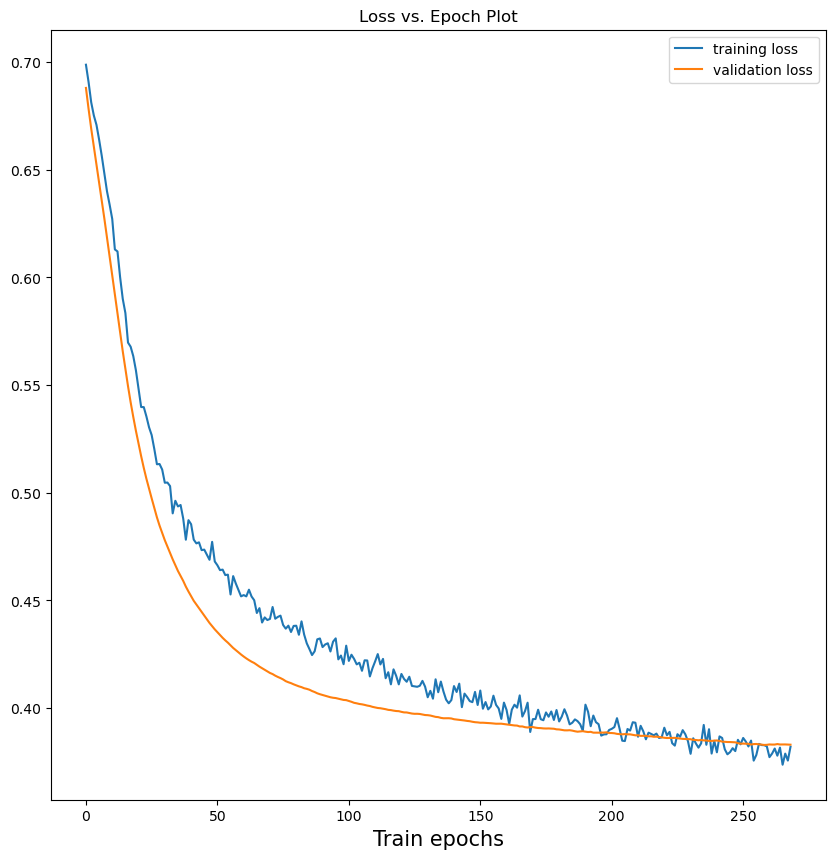

In [34]:
# build the neural network
model = build_model(
    num_features=X_train_final.shape[1],
    activation='relu',
    optimizer='Adam',
    learning_rate=0.00001
)

# early stopping callback 
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# fit the model
history = model.fit(
    x=X_train_final,
    y=y_train_final,
    epochs=1000,
    batch_size=32,
    callbacks=[early_stopping],
    validation_data=[X_val_final, y_val_final]
)

# Retrieve the training metrics (after each train epoch) and the final validation
# accuracy.
train_accuracy = history.history['loss']
val_accuracy = history.history['val_loss']
plt.figure(figsize=(10,10))
plt.plot(train_accuracy, label='training loss')
plt.plot(val_accuracy, label='validation loss')
plt.xlabel('Train epochs')
plt.title('Loss vs. Epoch Plot')
plt.legend()
plt.show()

In [44]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,997 (582.02 KB)

 Trainable params: 49,665 (194.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 99,332 (388.02 KB)

## Model Evaluation  

Review test data to see how our model holds up.

In [39]:
# predict probabilities for candidate
y_test_proba = model.predict(X_test_final)

# based on threshold, classify the candidates and false positives
y_test_pred = (y_test_proba > 0.35).astype(int)

y_test_pred[:5]


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array([[1],
       [0],
       [1],
       [0],
       [1]])

In [40]:
# get all metrics (accuracy, precision, recall, f1, and confusion matrix)
test_accuracy = accuracy_score(y_test_final, y_test_pred)
report = classification_report(y_test_final, y_test_pred, target_names=['FALSE POSITIVE', 'CANDIDATE'])
cm = confusion_matrix(y_test_final, y_test_pred)

print(f'Test Accuracy: {test_accuracy:.5f}')
print('Classification Report:')
print(report)
print('Confusion Matrix:')
print(cm)



Test Accuracy: 0.80852
Classification Report:
                precision    recall  f1-score   support

FALSE POSITIVE       0.89      0.71      0.79       934
     CANDIDATE       0.75      0.91      0.82       873

      accuracy                           0.81      1807
     macro avg       0.82      0.81      0.81      1807
  weighted avg       0.82      0.81      0.81      1807

Confusion Matrix:
[[667 267]
 [ 79 794]]


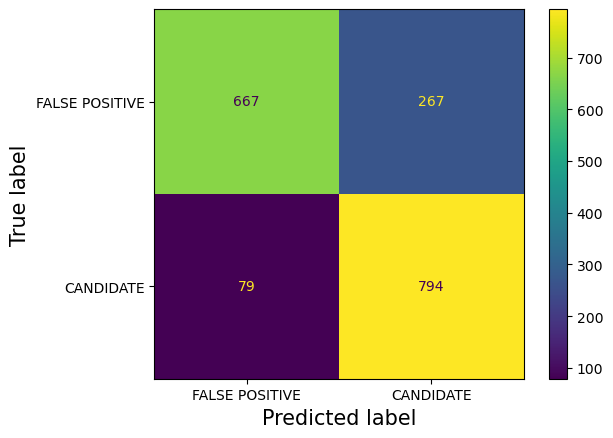

In [43]:
# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FALSE POSITIVE', 'CANDIDATE'])
disp.plot()